In [4]:
import os
import cv2
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.applications.resnet import ResNet50
from keras.backend.tensorflow_backend import set_session

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)

HOME = os.path.expanduser('~')
DB_PATH = HOME + '/Datasets/instance_seg/checked/'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [3]:
def decoder(x, prefix='decoder1'):
    x = layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same', name=prefix + '_conv1')(x)
    x = layers.BatchNormalization(name=prefix + '_bn1')(x)
    x = layers.Activation('relu', name=prefix + '_act1')(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', name=prefix + '_conv2')(x)
    x = layers.BatchNormalization(name=prefix + '_bn2')(x)
    x = layers.Activation('relu', name=prefix + '_act2')(x)
    
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name=prefix + '_up1')(x)

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', name=prefix + '_conv3')(x)
    x = layers.BatchNormalization(name=prefix + '_bn3')(x)
    x = layers.Activation('relu', name=prefix + '_act3')(x)

    return x

In [4]:
def AutoEncoder():
    _input = layers.Input(shape=(224, 224, 3))
    model = ResNet50(include_top=False, weights='imagenet', input_tensor=_input)
    
    encoder_top = model.get_layer('conv4_block6_out')
    x = encoder_top.output
    
    x = decoder(x, prefix='decoder1')
    x = layers.concatenate([x, model.get_layer('conv3_block4_out').output], axis=-1)
    x = decoder(x, prefix='decoder2')
    x = layers.concatenate([x, model.get_layer('conv2_block3_out').output], axis=-1)
    x = decoder(x, prefix='decoder3')
    x = layers.concatenate([x, model.get_layer('conv1_relu').output], axis=-1)
    x = decoder(x, prefix='decoder4')
    
    x = layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='pre_out_conv1')(x)
    x = layers.Activation('sigmoid', name='output')(x)
    return models.Model(inputs=_input, outputs=x)

In [5]:
model = AutoEncoder()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [3]:
images = glob(DB_PATH + '/images/*')
len(images)

13999

In [4]:
def dataLoader():
    images = glob(DB_PATH + '/images/*')
    X = []
    y = []
    for img in tqdm(images[:10000]):
        filename = img.split('/')[-1]
        image = cv2.imread(img)
        image = image[:, :, ::-1]
        image = cv2.resize(image, (224, 224))
        mask = cv2.imread(DB_PATH + '/masks/' + filename, 0) / 255
        mask = cv2.resize(mask, (224, 224), interpolation = cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1)
        X.append(image)
        y.append(mask)
        
    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)
        

In [9]:
X,Y = dataLoader()
print(X.shape, Y.shape)

100%|██████████| 10000/10000 [03:27<00:00, 48.08it/s]


(10000, 224, 224, 3) (10000, 224, 224, 1)


In [13]:
mc = keras.callbacks.ModelCheckpoint('models/weights_{epoch:04d}.h5', period=2)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy')

In [14]:
model_result = model.fit(X, Y, batch_size = 20, epochs=40, callbacks=[mc])

Epoch 1/40
10000/10000 [==============================] - 141s 14ms/step - loss: 0.1132
Epoch 2/40
10000/10000 [==============================] - 134s 13ms/step - loss: 0.0927
Epoch 3/40
10000/10000 [==============================] - 135s 14ms/step - loss: 0.0822
Epoch 4/40
10000/10000 [==============================] - 134s 13ms/step - loss: 0.0744
Epoch 5/40
10000/10000 [==============================] - 134s 13ms/step - loss: 0.0666
Epoch 6/40
10000/10000 [==============================] - 134s 13ms/step - loss: 0.0662
Epoch 7/40
10000/10000 [==============================] - 134s 13ms/step - loss: 0.0546
Epoch 8/40
10000/10000 [==============================] - 132s 13ms/step - loss: 0.0610
Epoch 9/40
10000/10000 [==============================] - 132s 13ms/step - loss: 0.0490
Epoch 10/40
10000/10000 [==============================] - 132s 13ms/step - loss: 0.0474
Epoch 11/40
10000/10000 [==============================] - 132s 13ms/step - loss: 0.0493
Epoch 12/40
10000/10000 [=====

In [17]:
model_path = 'models/weights_0036_0.0226.h5'
model = keras.models.load_model(model_path)

img.shape: (270, 480, 3), mask.shape: (270, 480)


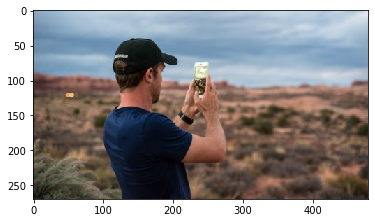

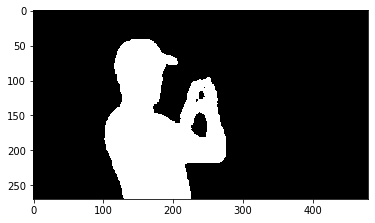

In [28]:
img = cv2.imread(HOME + '/Downloads/person/images/arches-utah-iphone-apple-smartphone-cameraphone-photo-photography-1.jpg')
img = img[:, :, ::-1]
h, w, _ = img.shape
tmp = cv2.resize(img, (224, 224))

mask = model.predict(np.array([tmp]))
mask = mask[0]
mask = cv2.resize(mask, (w, h))
print("img.shape: {}, mask.shape: {}".format(img.shape, mask.shape))

plt.imshow(img)
plt.show()
plt.imshow(mask > .5, cmap='gray')
plt.show()

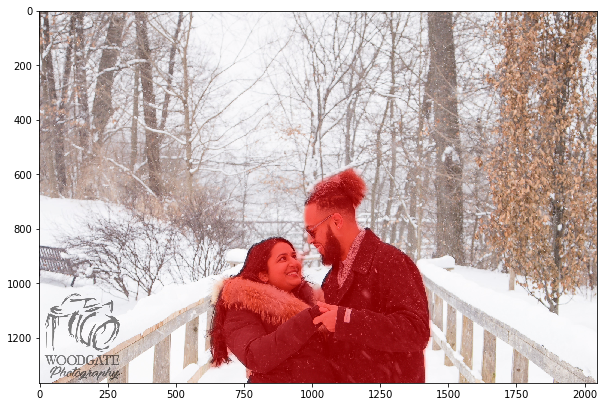

In [27]:
alpha = .5
color = np.dstack([np.ones((h, w)) * 255, np.zeros((h, w)), np.zeros((h, w))])
_mask = np.dstack([mask, mask, mask])

result_image = ((1 - alpha) * img + alpha * color) * _mask + (1 - _mask) * img

plt.figure(figsize=(10, 10))
plt.imshow(result_image.astype(np.uint8))